## SimCLR Training

In [3]:
%load_ext autoreload
%autoreload 2

In [16]:
import os
import pickle
import scipy
import datetime
import numpy as np
import tensorflow as tf
import simclr_utitlities
import transformations
import simclr_models
import sys
import matplotlib.pyplot as plt
sys.path.append('../../')   # Add parent directory to Python path

seed = 1
tf.random.set_seed(seed)
np.random.seed(seed)

In [34]:
# Parameters
working_directory = "../../models/"
window_size = 50
input_shape = (window_size, 3)
batch_size = 512
#Number of samples processed together in one training step. Larger batch sizes can speed up training but require more memory.
decay_steps = 1000
#Number of steps after which the learning rate decays (used for learning rate scheduling).
epochs = 200
temperature = 0.1


In [17]:
# # transformation_indices = [2] # Use rotation transformation only
# # transformation_indices = [1, 2] # Use Scaling and rotation transformation
# transformation_indices = [5, 7] # Use channel shuffle and permutation transformation

# transform_funcs_vectorized = [
#     # 0. Adding random Gaussian noise.
#     transformations.noise_transform_vectorized, 
#     # 1. Scaling by a random factor
#     transformations.scaling_transform_vectorized, 
#     # 2. Applying a random 3D rotation
#     transformations.rotation_transform_vectorized, 
#     # 3. Inverting the signals.
#     transformations.negate_transform_vectorized, 
#     # 4. Reversing the direction of time
#     transformations.time_flip_transform_vectorized, 
#     # 5. Randomly scrambling sections of the signal.
#     transformations.time_segment_permutation_transform_improved, 
#     # 6. Stretching and warping the time-series
#     transformations.time_warp_transform_low_cost, 
#     # 7. Shuffling the different channels.
#     transformations.channel_shuffle_transform_vectorized
# ]
# # transform_funcs_names = ['noised', 'scaled', 'rotated', 'negated', 'time_flipped', 'permuted', 'time_warped', 'channel_shuffled']
# # Optionally, you can use a combined transformation function for data augmentation.
# transformation_function = simclr_utitlities.generate_combined_transform_function(
#     transform_funcs_vectorized, 
#     indices=transformation_indices
# )

In [18]:
#A parameter for the SimCLR loss function that controls how sharply similarities are measured.
# transform_funcs = [
#     transformations.scaling_transform_vectorized, # Use Scaling trasnformation
#     transformations.rotation_transform_vectorized # Use rotation trasnformation
# ]
transform_funcs = [
    transformations.time_segment_permutation_transform_improved, 
    transformations.channel_shuffle_transform_vectorized
]
#List of data augmentation functions to apply to the input data. Here, only rotation is used.
transformation_function = simclr_utitlities.generate_composite_transform_function_simple(transform_funcs)

0 <function time_segment_permutation_transform_improved at 0x000001B48BB116C0>
1 <function channel_shuffle_transform_vectorized at 0x000001B48BB11620>


In [24]:
# Time
start_time = datetime.datetime.now()
start_time_str = start_time.strftime("%Y%m%d-%H%M%S")
#Formats the date and time as a string like 20250827-153045 (for filenames, logs, etc.).
tf.keras.backend.set_floatx('float32')
#Sets TensorFlow to use 32-bit floating point numbers for all computations (standard for deep learning).

In [26]:
# Load data
with open('../../data/TrainTest_one/X_train_data_normalized.pkl', 'rb') as f:
    np_train_data = pickle.load(f)
with open('../../data/TrainTest_one/y_train_label_onehot.pkl', 'rb') as f:
    np_train_labels = pickle.load(f)

In [37]:
# Create a cosine-decayed learning rate schedule and SGD optimizer for training.
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.1, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.SGD(lr_decayed_fn)

# Build the base model and attach the SimCLR head for contrastive learning.
base_model = simclr_models.create_base_model(input_shape, model_name="base_model")
simclr_model = simclr_models.attach_simclr_head(base_model)
simclr_model.summary()

# Train the SimCLR model using the specified transformation function and optimizer.
trained_simclr_model, epoch_losses = simclr_utitlities.simclr_train_model(
    simclr_model, 
    np_train_data, 
    optimizer, 
    batch_size, 
    transformation_function,
    temperature=temperature, 
    epochs=epochs, 
    is_trasnform_function_vectorized=True, 
    verbose=1
)

# Save the trained SimCLR model to disk for later use.
simclr_model_save_path = f"{working_directory}{start_time_str}_simclr.hdf5"
trained_simclr_model.save(simclr_model_save_path)

Model: "base_model_simclr"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 50, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 27, 32)         │         2,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 27, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 12, 64)         │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 5, 96)          │        49,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 5, 96)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 96)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 50)             │         6,450 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,594 (580.45 KB)

 Trainable params: 148,594 (580.45 KB)

 Non-trainable params: 0 (0.00 B)

epoch: 1 loss: 13.310
epoch: 2 loss: 13.148
epoch: 3 loss: 12.630
epoch: 4 loss: 11.576
epoch: 5 loss: 11.524
epoch: 6 loss: 11.744
epoch: 7 loss: 11.189
epoch: 8 loss: 10.384
epoch: 9 loss: 10.123
epoch: 10 loss: 10.339
epoch: 11 loss: 9.866
epoch: 12 loss: 10.511
epoch: 13 loss: 10.505
epoch: 14 loss: 10.486
epoch: 15 loss: 9.878
epoch: 16 loss: 10.525
epoch: 17 loss: 9.638
epoch: 18 loss: 9.268
epoch: 19 loss: 9.369
epoch: 20 loss: 9.737
epoch: 21 loss: 9.211
epoch: 22 loss: 9.441
epoch: 23 loss: 9.352
epoch: 24 loss: 8.992
epoch: 25 loss: 8.745
epoch: 26 loss: 8.831
epoch: 27 loss: 9.307
epoch: 28 loss: 8.933
epoch: 29 loss: 8.824
epoch: 30 loss: 8.955
epoch: 31 loss: 9.010
epoch: 32 loss: 8.524
epoch: 33 loss: 9.261
epoch: 34 loss: 9.096
epoch: 35 loss: 9.549
epoch: 36 loss: 8.734
epoch: 37 loss: 8.393
epoch: 38 loss: 8.844
epoch: 39 loss: 8.685
epoch: 40 loss: 8.133
epoch: 41 loss: 8.231
epoch: 42 loss: 8.617
epoch: 43 loss: 8.262
epoch: 44 loss: 8.591
epoch: 45 loss: 8.318
epoch

epoch: 199 loss: 5.855
epoch: 200 loss: 5.737


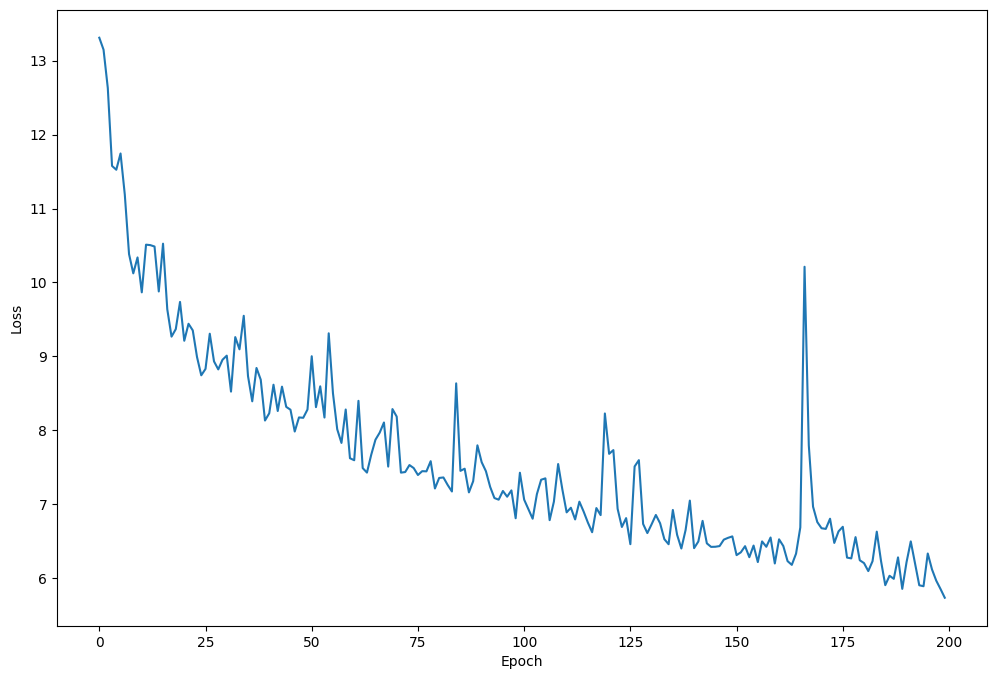

In [38]:
plt.figure(figsize=(12,8))
plt.plot(epoch_losses)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

## Fine-tuning and Evaluation

### Linear Model:
This block performs linear evaluation on top of the pretrained SimCLR base model.


In [17]:
# Parameters
total_epochs = 100
batch_size = 64
tag = "linear_eval"
output_shape = 7


In [21]:
simclr_model_save_path = '../../models/20250903-150842_simclr.hdf5'
working_directory = "../../models/"

In [28]:
# load validation data
with open('../../data/TrainTest_one/X_val_data_normalized.pkl', 'rb') as f:
    np_val_data = pickle.load(f)
with open('../../data/TrainTest_one/y_val_label_onehot.pkl', 'rb') as f:
    np_val_labels = pickle.load(f)

In [29]:
simclr_model = tf.keras.models.load_model(simclr_model_save_path)
linear_evaluation_model = simclr_models.create_linear_model_from_base_model(simclr_model, output_shape, intermediate_layer=7)

# Use Adam optimizer for linear evaluation
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
linear_evaluation_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy', 'AUC', 'Precision', 'Recall']
)

# 2. Sets up a ModelCheckpoint callback to save the best model (lowest validation loss).
linear_eval_best_model_file_name = f"{working_directory}{start_time_str}_simclr_{tag}.keras"
best_model_callback = tf.keras.callbacks.ModelCheckpoint(
    linear_eval_best_model_file_name,
    monitor='val_loss', 
    mode='min', 
    save_best_only=True, 
    save_weights_only=False, 
    verbose=0,
)

# 3. Trains the linear evaluation model using the training and validation data.
training_history = linear_evaluation_model.fit(
    x = np_train_data,
    y = np_train_labels,
    batch_size=batch_size,
    shuffle=True,
    epochs=total_epochs,
    callbacks=[best_model_callback],
    validation_data=(np_val_data, np_val_labels),
)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - AUC: 0.6237 - Precision: 0.7842 - Recall: 0.0467 - categorical_accuracy: 0.2439 - loss: 1.8073 - val_AUC: 0.7695 - val_Precision: 1.0000 - val_Recall: 0.2170 - val_categorical_accuracy: 0.3538 - val_loss: 1.5225
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.8019 - Precision: 0.8902 - Recall: 0.2545 - categorical_accuracy: 0.3664 - loss: 1.4835 - val_AUC: 0.8183 - val_Precision: 1.0000 - val_Recall: 0.2264 - val_categorical_accuracy: 0.4057 - val_loss: 1.4302
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.8370 - Precision: 0.8861 - Recall: 0.2501 - categorical_accuracy: 0.4568 - loss: 1.3894 - val_AUC: 0.8336 - val_Precision: 1.0000 - val_Recall: 0.2311 - val_categorical_accuracy: 0.4387 - val_loss: 1.3908
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8513 - Precision: 0.8980 - Recall: 0.2681 - categorical_accuracy: 0.4988 - loss: 1.3388 - val_AUC: 0.8444 - val_Precision: 0.9818 - val_Recall

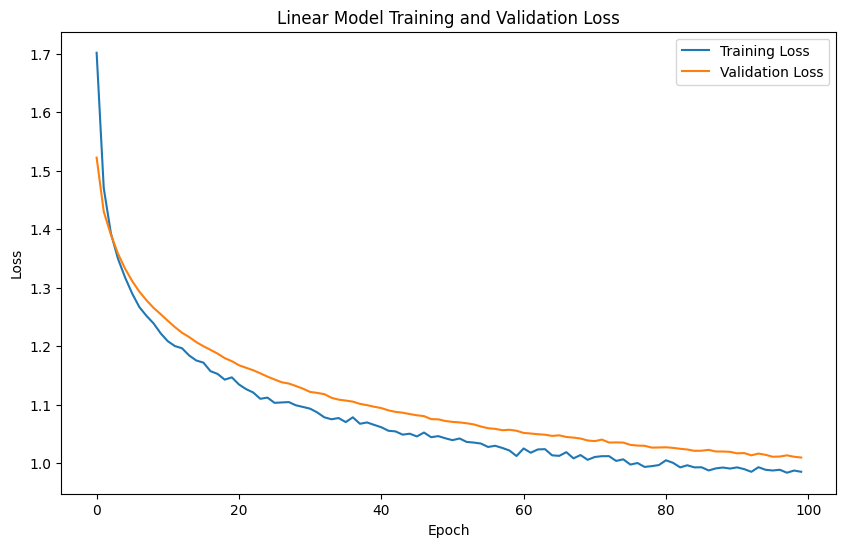

In [30]:
# Plot training and validation loss
plt.figure(figsize=(10,6))
plt.plot(training_history.history['loss'], label='Training Loss')
plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Linear Model Training and Validation Loss')
plt.legend()
plt.show()

In [31]:
# ...existing code...
batch_sizes = [32, 64, 128]
learning_rates = [0.0005, 0.001, 0.005]

results = []

for batch_size in batch_sizes:
    for lr in learning_rates:
        print(f"Training with batch_size={batch_size}, learning_rate={lr}")
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        linear_evaluation_model = simclr_models.create_linear_model_from_base_model(simclr_model, output_shape, intermediate_layer=7)
        linear_evaluation_model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['categorical_accuracy', 'AUC', 'Precision', 'Recall']
        )
        history = linear_evaluation_model.fit(
            x=np_train_data,
            y=np_train_labels,
            batch_size=batch_size,
            shuffle=True,
            epochs=total_epochs,
            validation_data=(np_val_data, np_val_labels),
            verbose=0
        )
        final_val_loss = history.history['val_loss'][-1]
        results.append((batch_size, lr, final_val_loss))

print("Results (batch_size, learning_rate, final_val_loss):")
for r in results:
    print(r)

Training with batch_size=32, learning_rate=0.0005
Training with batch_size=32, learning_rate=0.001
Training with batch_size=32, learning_rate=0.005
Training with batch_size=64, learning_rate=0.0005
Training with batch_size=64, learning_rate=0.001
Training with batch_size=64, learning_rate=0.005
Training with batch_size=128, learning_rate=0.0005
Training with batch_size=128, learning_rate=0.001
Training with batch_size=128, learning_rate=0.005
Results (batch_size, learning_rate, final_val_loss):
(32, 0.0005, 1.0294243097305298)
(32, 0.001, 0.9789192080497742)
(32, 0.005, 0.9467173218727112)
(64, 0.0005, 1.0741227865219116)
(64, 0.001, 1.0085828304290771)
(64, 0.005, 0.9390428066253662)
(128, 0.0005, 1.1168911457061768)
(128, 0.001, 1.0417579412460327)
(128, 0.005, 0.9456339478492737)


In [44]:
# load test data
with open('../../data/TrainTest_one/X_test_data.pkl', 'rb') as f:
    np_test_data = pickle.load(f)
with open('../../data/TrainTest_one/y_test_onehot.pkl', 'rb') as f:
    np_test_labels = pickle.load(f)

In [46]:
# 4. Loads the best saved model and evaluates its performance on the test set.
linear_eval_best_model = tf.keras.models.load_model(linear_eval_best_model_file_name)

# 5. Also evaluates the final model from the last epoch for comparison.
np_test_data = np.array(np_test_data)  # Ensure test data is a single array
print("Model with lowest validation Loss:")
print(simclr_utitlities.evaluate_model_simple(linear_eval_best_model.predict(np_test_data), np_test_labels, return_dict=True))
print("Model in last epoch")
print(simclr_utitlities.evaluate_model_simple(linear_evaluation_model.predict(np_test_data), np_test_labels, return_dict=True))

Model with lowest validation Loss:
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
{'Confusion Matrix': array([[ 0,  0,  0, 38,  0,  0,  0],
       [ 0,  0,  0, 38,  0,  0,  0],
       [ 0,  0,  0, 38,  0,  0,  0],
       [ 0,  0,  0, 38,  0,  0,  0],
       [ 0,  0,  0, 27, 11,  0,  0],
       [ 0,  0,  0, 38,  0,  0,  0],
       [ 0,  0,  0, 38,  0,  0,  0]]), 'F1 Macro': 0.10119503676653498, 'F1 Micro': 0.18421052631578946, 'F1 Weighted': 0.10119503676653499, 'Precision': 0.16414565826330532, 'Recall': 0.18421052631578946, 'Kappa': np.float64(0.04824561403508776)}
Model in last epoch


c:\Users\liuzi\miniconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input']
Received: inputs=Tensor(shape=(32, 50, 3))
  warnings.warn(msg)
c:\Users\liuzi\miniconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input']
Received: inputs=Tensor(shape=(None, 50, 3))
  warnings.warn(msg)
c:\Users\liuzi\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\liuzi\miniconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input']
Received: inputs=T

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
{'Confusion Matrix': array([[ 0,  0,  0, 38,  0,  0,  0],
       [ 0,  0,  0, 38,  0,  0,  0],
       [ 0,  0,  0, 38,  0,  0,  0],
       [ 0,  0,  0, 38,  0,  0,  0],
       [ 0,  0,  0, 27, 11,  0,  0],
       [ 0,  0,  0, 38,  0,  0,  0],
       [ 0,  0,  0, 38,  0,  0,  0]]), 'F1 Macro': 0.10119503676653498, 'F1 Micro': 0.18421052631578946, 'F1 Weighted': 0.10119503676653499, 'Precision': 0.16414565826330532, 'Recall': 0.18421052631578946, 'Kappa': np.float64(0.04824561403508776)}


c:\Users\liuzi\miniconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input']
Received: inputs=Tensor(shape=(None, 50, 3))
  warnings.warn(msg)
c:\Users\liuzi\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
